# GEOG606 - Spatial Auto-correlation
#### Zachary Burnett 2022-04-12

In [88]:
from datetime import datetime
from pathlib import Path

import numpy
import pandas
from stormevents import StormEvent
import geopandas
import xarray
from geopandas import GeoDataFrame, GeoSeries
from matplotlib import pyplot
from cartopy import crs
from stormevents.coops import COOPS_Station, coops_stations

In [89]:
data_directory = Path() / 'data'

#### retrieve NaturalEarth country boundaries

In [90]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

## NOAA CO-OPS water level stations

In [91]:
stations = coops_stations(station_status='active')
stations

,nws_id,name,state,status,removed,geometry
nos_id,,,,,,
1600012,46125,QREB buoy,,active,<NA>,POINT (122.62500 37.75000)
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,POINT (-177.37500 28.21875)
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,POINT (144.62500 13.44531)
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,POINT (144.75000 13.42969)
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,POINT (-170.75000 -14.27344)
...,...,...,...,...,...,...
8729840,PCLF1,Pensacola,FL,active,"2022-04-01 10:00:00,2022-04-01 00:00:00,2020-0...",POINT (-87.18750 30.40625)
8775132,LQAT2,La Quinta Channel North,TX,active,"2022-04-04 00:00:00,2022-02-18 00:00:00,2022-0...",POINT (-97.25000 27.87500)
8735180,DILA1,Dauphin Island,AL,active,"2022-04-11 23:58:00,2019-07-18 10:00:00,2018-0...",POINT (-88.06250 30.25000)


Text(0.5, 1.0, 'active NOAA CO-OPS sensor stations as of 2022-05-03')

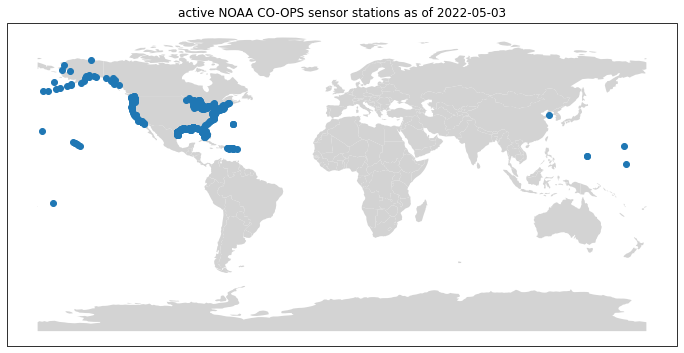

In [92]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
stations.plot(ax=axis)
axis.set_title(f'active NOAA CO-OPS sensor stations as of {datetime.now():%Y-%m-%d}')

## Hurricane Florence (2018)

In [93]:
storm = StormEvent('florence', 2018)
storm

StormEvent(name='FLORENCE', year=2018, start_date=Timestamp('2018-08-30 06:00:00'), end_date=Timestamp('2018-09-18 12:00:00'))

In [94]:
best_track = storm.track(advisories=['BEST'])
best_track

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


VortexTrack('AL062018', Timestamp('2018-08-30 06:00:00'), Timestamp('2018-09-18 12:00:00'), <ATCF_FileDeck.BEST: 'b'>, [<ATCF_Advisory.BEST: 'BEST'>], None)

In [95]:
track_bounds = numpy.stack([
    best_track.data[['longitude', 'latitude']].min().values,
    best_track.data[['longitude', 'latitude']].max().values,
], axis=1)
track_bounds[:, 0] -= 1
track_bounds[:, 1] += 1
track_bounds

array([[-83.6, -15.9],
       [ 11.8,  43.2]])

In [96]:
wind_swath_34kt = best_track.wind_swaths(wind_speed=34)['BEST']['20180830T060000']

Text(0.5, 1.0, 'Hurricane Florence (2018)')

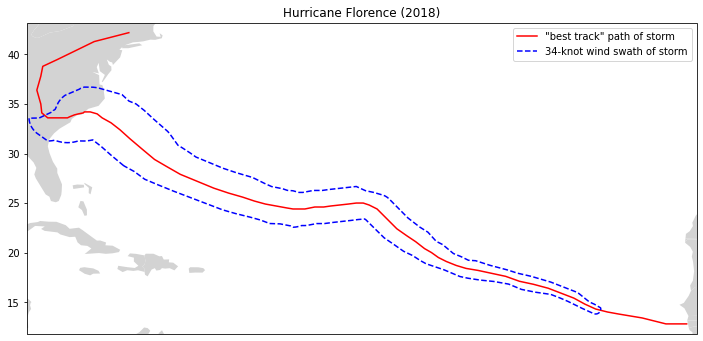

In [97]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*track_bounds[0, :])
axis.set_ylim(*track_bounds[1, :])

best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')

axis.legend()
axis.set_title('Hurricane Florence (2018)')

### load water level data modeled by the ADCIRC oceanic circulation model during Hurricane Florence (2018) within a 34-knot wind swath of the storm's path

In [98]:
filename = data_directory / 'run_20220502_florence2018_coopsstations' / 'runs' / 'unperturbed' / 'fort.61.nc'
modeled_water_levels = xarray.open_dataset(filename, drop_variables=['neta', 'nvel', 'max_nvdll', 'max_nvell'])
modeled_water_levels['station_name'] = modeled_water_levels['station_name'].astype(str).astype(int)
modeled_water_levels

<xarray.Dataset>
Dimensions:       (time: 1440, station: 164)
Coordinates:
  * time          (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06...
Dimensions without coordinates: station
Data variables:
    station_name  (station) int64 8726412 8726679 8726694 ... 8423898 8726667
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [99]:
modeled_water_levels = modeled_water_levels.rename({
    'station_name': 'nos_id',
})
modeled_water_levels = modeled_water_levels.assign_coords({
    'station': modeled_water_levels['nos_id'],
    'x': modeled_water_levels['x'],
    'y': modeled_water_levels['y'],
})
modeled_water_levels = modeled_water_levels.drop(['nos_id'])
modeled_water_levels = modeled_water_levels.rename({
    'station': 'nos_id',
})
modeled_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 164)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Data variables:
    zeta     (time, nos_id) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [100]:
modeled_water_levels['zeta']

<xarray.DataArray 'zeta' (time: 1440, nos_id: 164)>
[236160 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Attributes:
    long_name:      water surface elevation above geoid
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [101]:
stations_bounds = numpy.array([
    [modeled_water_levels['x'].min(), modeled_water_levels['x'].max()],
    [modeled_water_levels['y'].min(), modeled_water_levels['y'].max()],
])
stations_bounds[:, 0] -= 1
stations_bounds[:, 1] += 1
stations_bounds

array([[-84.875   , -66.      ],
       [ 24.734375,  45.90625 ]])

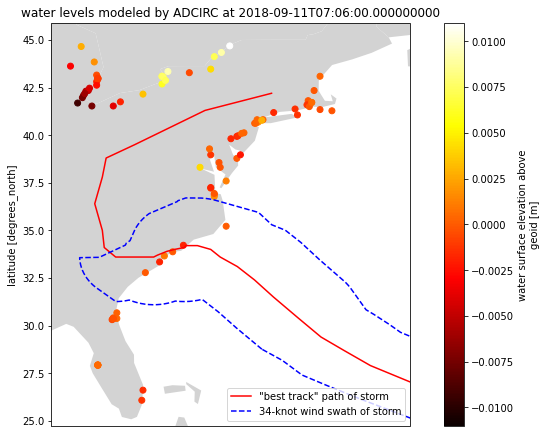

In [102]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

modeled_water_levels_at_selected_time = modeled_water_levels.isel(time=10)
modeled_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='zeta', cmap='hot', ax=axis)
axis.set_title(f'water levels modeled by ADCIRC at {modeled_water_levels_at_selected_time["time"].values}')

axis.legend()

### retrieve water level data observed by NOAA CO-OPS during Hurricane Florence (2018) within the 34-knot isotach of the storm

In [103]:

observed_water_levels_filename = data_directory / 'florence2018_east_coast_water_levels.nc'

if not observed_water_levels_filename.exists():
    stations = [
        COOPS_Station(float(nos_id.values))
        for nos_id in modeled_water_levels['nos_id']
    ]
    data = [
        station.product(
            'water_level',
            start_date=pandas.to_datetime(min(modeled_water_levels['time']).values),
            end_date=pandas.to_datetime(max(modeled_water_levels['time']).values),
            units='metric',
        )
        for station in stations
    ]
    data = [
        entry for entry in data
        if numpy.product(list(entry.sizes.values())) > 0
    ]
    observed_water_levels = xarray.combine_by_coords(data)
    observed_water_levels.to_netcdf(observed_water_levels_filename)
else:
    observed_water_levels = xarray.open_dataset(observed_water_levels_filename)

observed_water_levels

<xarray.Dataset>
Dimensions:  (t: 1440, nos_id: 111)
Coordinates:
  * t        (t) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) <U5 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62
Data variables:
    v        (nos_id, t) float32 74.27 74.27 74.27 74.27 ... 176.9 176.9 176.9
    s        (nos_id, t) float32 0.001 0.0 0.0 0.0 0.0 ... 0.001 0.0 0.0 0.0 0.0
    f        (nos_id, t) object '0,0,0,0' '0,0,0,0' ... '0,0,0,0' '0,0,0,0'
    q        (nos_id, t) object 'v' 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v' 'v'

In [104]:
observed_water_levels['v']

<xarray.DataArray 'v' (nos_id: 111, t: 1440)>
array([[ 74.27 ,  74.268,  74.267, ...,  74.274,  74.273,  74.274],
       [ 74.541,  74.542,  74.544, ...,  74.524,  74.523,  74.527],
       [  6.736,   6.604,   6.47 , ...,   3.643,   3.762,   3.877],
       ...,
       [176.94 , 176.951, 176.966, ..., 176.923, 176.908, 176.909],
       [176.933, 176.925, 176.934, ..., 176.909, 176.932, 176.929],
       [176.996, 176.995, 176.996, ..., 176.924, 176.921, 176.916]],
      dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) <U5 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### normalize observed water levels by subtracting the time average for each station

In [105]:
observed_water_levels['normalized_v'] = observed_water_levels['v'] - observed_water_levels['v'].mean(dim='t')
observed_water_levels['normalized_v']

<xarray.DataArray 'normalized_v' (nos_id: 111, t: 1440)>
array([[-1.9378662e-02, -2.1377563e-02, -2.2377014e-02, ...,
        -1.5373230e-02, -1.6372681e-02, -1.5373230e-02],
       [ 1.2893677e-02,  1.3893127e-02,  1.5892029e-02, ...,
        -4.1046143e-03, -5.1040649e-03, -1.1062622e-03],
       [ 2.3347917e+00,  2.2027917e+00,  2.0687914e+00, ...,
        -7.5820851e-01, -6.3920832e-01, -5.2420831e-01],
       ...,
       [-1.1413574e-02, -4.1198730e-04,  1.4587402e-02, ...,
        -2.8411865e-02, -4.3411255e-02, -4.2419434e-02],
       [-5.9204102e-03, -1.3916016e-02, -4.9133301e-03, ...,
        -2.9922485e-02, -6.9122314e-03, -9.9182129e-03],
       [ 1.5792847e-02,  1.4785767e-02,  1.5792847e-02, ...,
        -5.6213379e-02, -5.9204102e-02, -6.4208984e-02]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) <U5 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### compare modeled water levels vs observed water levels

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

observed_water_levels_at_selected_time = observed_water_levels.isel(t=0)
observed_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='normalized_v', cmap='cool', ax=axis)
axis.set_title(f'water levels observed by NOAA CO-OPS at {observed_water_levels_at_selected_time["t"].values}')

axis.legend()

Text(0.5, 1.0, 'water levels observed by NOAA CO-OPS at each station')

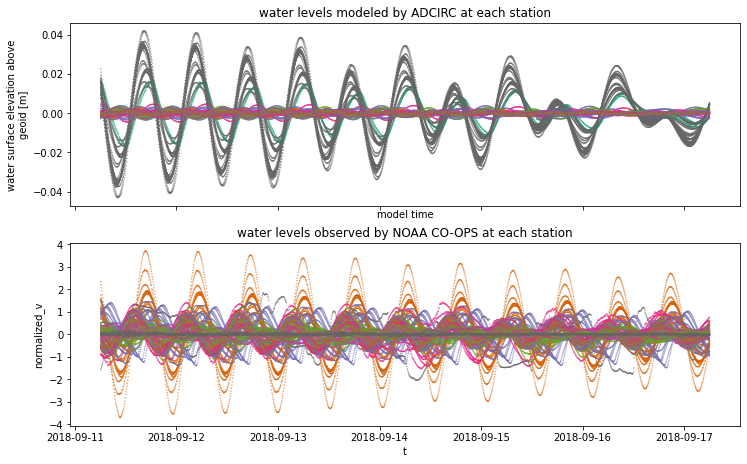

In [108]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis_1, axis_2 = figure.subplots(2, 1, sharex='all')

modeled_water_levels.plot.scatter(x='time', y='zeta', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_1)
observed_water_levels.plot.scatter(x='t', y='normalized_v', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_2)

axis_1.set_title('water levels modeled by ADCIRC at each station')
axis_2.set_title('water levels observed by NOAA CO-OPS at each station')

In [109]:
rmse = ((modeled_water_levels['zeta'] - observed_water_levels['normalized_v']) ** 2).mean(dim='time') ** 0.5
rmse

<xarray.DataArray (nos_id: 111, t: 1440)>
array([[0.01918446, 0.02001632, 0.02001632, ..., 0.01789469, 0.02592092,
        0.01820968],
       [0.02691797, 0.02630343, 0.02691797, ..., 0.05914766, 0.0619512 ,
        0.06667924],
       [0.01122009, 0.0127511 , 0.01649163, ..., 0.03284398, 0.02546544,
        0.02819685],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * nos_id   (nos_id) int64 9044036 9075035 9052076 ... 8720625 8423898 8726667
  * t        (t) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    nws_id   (nos_id) <U5 'FWNM4' 'ESVM4' 'OCTN6' ... 'RCYF1' 'FTPN3' 'MCYF1'

In [ ]:
rmse.to_series().plot.bar()

## calculate spatial auto-correlation based on `v` attribute of water levels

In [ ]:
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, MultiPoint

### define the column of interest

In [ ]:
first_value_of_interest = 'v'

### build Voronoi regions from points

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
voronoi_regions = Voronoi(numpy.stack([modeled_water_levels['x'], modeled_water_levels['y']], axis=1))
voronoi_regions

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

voronoi_plot_2d(
    voronoi_regions,
    color='darkgrey',
    show_points=True,
    show_vertices=False,
    ax=axis,
)

### add voronoi regions to water levels dataframe

In [ ]:
polygons = {}
for region_index, region in enumerate(voronoi_regions.regions):
    if region_index in voronoi_regions.point_region:
        point_indices = voronoi_regions.point_region[voronoi_regions.point_region == region_index]
        points = voronoi_regions.points[[index for index in point_indices if index != -1]]
        point = points[0, :]
        entry = modeled_water_levels.where(
            (modeled_water_levels['x'] == point[0]) &
            (modeled_water_levels['y'] == point[1]),
            drop=True,
        )
        polygon = Polygon([voronoi_regions.vertices[vertex_index] for vertex_index in region if vertex_index != -1])
        polygons[int(entry['nos_id'][0].values)] = polygon
polygons = GeoSeries(polygons)
polygons

In [ ]:
water_levels = modeled_water_levels['zeta'].to_dataframe()
water_levels = GeoDataFrame(water_levels, geometry=geopandas.points_from_xy(water_levels['x'], water_levels['y']))
water_levels

In [ ]:
water_levels['region'] = polygons
water_levels

In [ ]:
water_levels['point'] = water_levels['geometry']
water_levels

In [ ]:
# water_levels = water_levels.loc[polygons.index, :]
water_levels = GeoDataFrame(
    water_levels,
    geometry=water_levels['region'],
)
water_levels

In [ ]:
water_levels = water_levels.clip(
    MultiPoint(water_levels['point'].tolist()).convex_hull,
)
water_levels

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

observed_water_levels.plot(column=first_value_of_interest, edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=observed_water_levels[first_value_of_interest].min(),
        vmax=observed_water_levels[first_value_of_interest].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)
colorbar.set_label(first_value_of_interest, rotation=270)

### univariate spatial auto-correlation

In [ ]:
from libpysal.weights import Queen, Rook
from esda.moran import Moran
from splot.esda import plot_moran

geopandas.options.use_pygeos = True

#### rook connectivity

In [ ]:
rook_weights = Rook.from_dataframe(observed_water_levels)

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rook_weights.plot(
    water_levels.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### global Moran's I

In [ ]:
rook_morans_i = Moran(
    water_levels[[first_value_of_interest]].values,
    rook_weights,
)
rook_morans_i.I

In [ ]:
plot_moran(
    rook_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [ ]:
rook_morans_i.p_sim

#### queen connectivity

In [ ]:
queen_weights = Queen.from_dataframe(observed_water_levels)

In [ ]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

queen_weights.plot(
    water_levels.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### global Moran's I

In [ ]:
queen_morans_i = Moran(
    water_levels[[first_value_of_interest]].values,
    queen_weights,
)
queen_morans_i.I

In [ ]:
plot_moran(
    queen_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [ ]:
queen_morans_i.p_sim